The number of samples:2400	


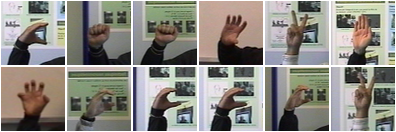

In [1]:
--One--Load Datas
require('image')
require('nn')
require('optim')
require('itorch.Plot')
require('./guestureData')

torch.setdefaulttensortype('torch.FloatTensor')
 print('The number of samples:'..#allSamples)
local guestures = {}
for i = 1, 12 do
    guestures[i] = image.loadPNG(allSamples[i].fileName, 3);
end
itorch.image(guestures)   

sampleLabel = {'A', 'B', 'C', 'Five', 'Point', 'V'}

In [2]:
--Two--Build Training datas and Test datas
trainsamples = {}
for i = 1, 2000 do
    allSamples[i].data = image.loadPNG(allSamples[i].fileName, 3)
    allSamples[i].data = allSamples[i].data-torch.mean(allSamples[i].data)   --Zero mean
    trainsamples[i] = allSamples[i]
end

testsamples = {}
for i = 2001, 2400 do
    allSamples[i].data = image.loadPNG(allSamples[i].fileName, 3)
    allSamples[i].data = allSamples[i].data-torch.mean(allSamples[i].data)   --Zero mean
    testsamples[i-#trainsamples] = allSamples[i]
end

In [3]:
--Three--Design the structure of  convolutional neural network
model = nn.Sequential() --3x64x64
model:add(nn.SpatialConvolution(3, 8, 3, 3, 1, 1, 1, 1)) --8x64x64
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2))--8x32x32
model:add(nn.SpatialConvolution(8, 16, 3, 3, 1, 1, 1, 1)) --16x32x32
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2))--16x16x16
model:add(nn.SpatialConvolution(16, 16, 3, 3, 1, 1, 1, 1)) --16x16x16
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2)) --16X8X8
model:add(nn.Reshape(16*8*8))
model:add(nn.Linear(16*8*8, 6))
model:add(nn.LogSoftMax()) --Softmax classifier
model:training()
criterion = nn.ClassNLLCriterion() -- Negative log loss function


In [4]:
--Four--Design the Training function
batchSize  = 32
itermIndex = 1
parameters, gradParameters = model:getParameters()
Dotrain = function(x)
    if x ~= parameters then
        parameters:copy(x)
    end
    
    gradParameters:zero()
    
    local f = 0 --mean value of error
    
    for i = 0, batchSize-1 do
       
        local targetIndex = (itermIndex + i) % #trainsamples
        local targetSample = trainsamples[targetIndex].data
        
        --forward propagation
        local output = model:forward(targetSample)
        local err = criterion:forward(output, trainsamples[targetIndex].y)
        f = f +err
        
        --backward propagation
        local df_do = criterion:backward(output, trainsamples[targetIndex].y)
        model:backward(targetSample, df_do)
    end
    f = f / batchSize
    gradParameters:div(batchSize)
    return f, gradParameters
end        

In [5]:
--Five--Design the optimization function
optimMethod = optim.adadelta
optimState = {} --default parameters

In [6]:
--Six--Train the neural network with samall samples(itermIndex = 1, i.e. the samples from 1 to 32 )
local maxLoop = 30
local errRecord = {
    seq = {},
    value = {}
}
itermIndex = 1
optimState = {}
for i = 1, maxLoop do
    local err
    _, err = optimMethod(Dotrain, parameters, optimState)
    errRecord.seq[i] = i
    errRecord.value[i] = err
end

local plot = itorch.Plot()
plot:line(errRecord.seq, errRecord.value, 'blue', 'yolo'):draw()
plot:title('Train the neural network with samall samples'):redraw()

In [7]:
--Seven--Train the overall samples
trainRecord = {
    seq = {},
    value = {}
}
testRecord = {
    pred = {},
    value = {}
}

oneEpoch = function()
    local maxLoop = math.floor(#trainsamples / batchSize)
    itermIndex = 1
    for i = 1, maxLoop do
        local err
        _, err = optimMethod(Dotrain, parameters, optimState)
        itermIndex = itermIndex + batchSize
        if (itermIndex > #trainsamples) then
            itermIndex = 1
        end
        
        trainRecord.seq[#trainRecord.seq + 1] = #trainRecord.seq + 1
        trainRecord.value[#trainRecord.value + 1] = err
    end
end

DoTest = function()
    local f = 0
    local rightPredNum = 0
    local pred = 0
    for i = 1, #testsamples do
        local output = model:forward(testsamples[i].data)
       _, pred = torch.max(output, 1)
        
        if (pred[1] == testsamples[i].y) then
            rightPredNum = rightPredNum + 1
        end
        
        local err = criterion:forward(output, testsamples[i].y)
        f = f + err
    end
    
    f = f / #testsamples
    table.insert(testRecord.value, f)
    table.insert(testRecord.pred, rightPredNum)
    return f, rightPredNum
end



In [30]:
--Eight--test the test samples
local beginT = sys.clock()
oneEpoch()
DoTest()
local endT = sys.clock()
print('>>>Running time: '..(endT - beginT))

local plot = itorch.Plot
plot:line(trainRecord.seq, trainRecord.value, 'black', 'yolo'):draw()
plot:title('Test on the overall samples'):redraw()

for i = 1, #testRecord.value do
    print('Epoches: '..i..'----loss = '..testRecord.value[i]..'-----prediction: '..(testRecord.pred[i]/#testsamples))
end

>>>Running time: 37.402383089066	


Epoches: 1----loss = 0.90897939847389-----prediction: 0.71	
Epoches: 2----loss = 0.51567673253661-----prediction: 0.87	
Epoches: 3----loss = 0.42141149269124-----prediction: 0.885	
Epoches: 4----loss = 0.38741260195409-----prediction: 0.895	
Epoches: 5----loss = 0.37367396884754-----prediction: 0.8925	


Epoches: 6----loss = 0.37212603954231-----prediction: 0.895	
Epoches: 7----loss = 0.38545367801314-----prediction: 0.9025	
Epoches: 8----loss = 0.40326598894187-----prediction: 0.9	
Epoches: 9----loss = 0.40330249916347-----prediction: 0.91	
Epoches: 10----loss = 0.44449234930189-----prediction: 0.915	
Epoches: 11----loss = 0.46392955466633-----prediction: 0.9125	


Epoches: 12----loss = 0.49300575773863-----prediction: 0.905	


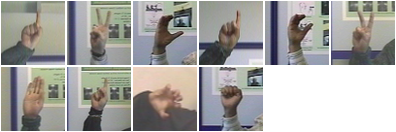

1Prediction--->>Point       RealValue--->>Point	
2Prediction--->>V       RealValue--->>V	
3Prediction--->>C       RealValue--->>C	
4Prediction--->>Point       RealValue--->>Point	
5Prediction--->>C       RealValue--->>C	
6Prediction--->>V       RealValue--->>V	
7Prediction--->>B       RealValue--->>B	
8Prediction--->>Point       RealValue--->>Point	
9Prediction--->>Five       RealValue--->>Five	
10Prediction--->>A       RealValue--->>A	


In [31]:
--Nine-Visualization on test samples
local testImages = {}
local testResult = {}
local testValue = {}
for i = 1, 10 do
    local pred
    local index = math.floor(math.random() * #testsamples) + 1
    local output = model:forward(testsamples[index].data)
    _, pred = torch.max(output, 1)
    table.insert(testImages, testsamples[index].data)
    table.insert(testResult, pred)
    table.insert(testValue, testsamples[index].y)
end

itorch.image(testImages)
for i = 1, #testResult do
    print(i..'Prediction--->>'..sampleLabel[testResult[i][1]]..'       RealValue--->>'..sampleLabel[testValue[i]])
    
end
    
    